# DATA7201 Project
The objective of this project is to use big data analytics techniques to explore the twitter dataset and draw some conclusions that inform decision makers. 

#### Method
- Use Pig to extract hashtag and geo tag data to then map with weather data to see if people tag there tweets more during good weather
- Define good weather
- Work out how to group geo-tagged tweets by bounds (for grouping with weather)
- List hashtags used
- Count number of geo-tagged as a proportion of tweets in general

#### To access hdfs directory
> hdfs dfs -ls /data/ProjectDataset

Don't need to give an output filename, but you do need to provide a new folder name for pig to dump the results into, one file will be an empty file "_SUCCESS" and the other contains the data.

Save data here:\
hdfs://data7201-node1.fabric.zones.eait.uq.edu.au:8020/user/s4575121/project_output

To copy data from the DATA7201 node to our laptops:
- copy from HDFS to DATA7201 node:
    - > hdfs dfs -get hdfs_path/source_file_name target_file_name
- copy from DATA7201 node to remote labs (do from remote labs):
    - > scp data7201-8b39743e.zones.eait.uq.edu.au:/home/s4575121/file_name .
- then scp from the local machine from the zone (do from local machine):
    - > scp s4575121@remote.labs.eait.uq.edu.au:/home/students/s4575121/file_name "C:\Users\robmw\OneDrive\Documents\01 Master of Data Science\INFS7201\project\datasets"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import os
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

### Read in the data

In [2]:
df = pd.read_csv('geo_tagged.csv', parse_dates=['time_stamp'])
df.head()

,id,time_stamp,longitude,latitude,type
0,483743110271205376,2014-06-30 22:45:19+00:00,-73.977142,40.780881,centroid
1,484021339431632896,2014-07-01 17:10:54+00:00,-70.778783,43.057659,centroid
2,484736120148598785,2014-07-03 16:31:11+00:00,-76.615181,39.396352,centroid
3,484752951890960384,2014-07-03 17:38:04+00:00,-73.977142,40.780881,centroid
4,484863140459741185,2014-07-04 00:55:55+00:00,-78.864466,44.035808,centroid


Summarise the dataset

In [3]:
print(len(df))
df['type'].value_counts()

1176197


point       1066878
centroid     109319
Name: type, dtype: int64

### Plot the data in space
Use the CEA projection  https://proj.org/operations/projections/cea.html

In [4]:
import reverse_geocoder as rg
df.head()

,id,time_stamp,longitude,latitude,type
0,483743110271205376,2014-06-30 22:45:19+00:00,-73.977142,40.780881,centroid
1,484021339431632896,2014-07-01 17:10:54+00:00,-70.778783,43.057659,centroid
2,484736120148598785,2014-07-03 16:31:11+00:00,-76.615181,39.396352,centroid
3,484752951890960384,2014-07-03 17:38:04+00:00,-73.977142,40.780881,centroid
4,484863140459741185,2014-07-04 00:55:55+00:00,-78.864466,44.035808,centroid


In [5]:
# get the citys and counties
def get_locations(df):
    # make a copy of the dataframe
    copy = df.copy()       
    copy['coordinates'] = list(zip(copy['latitude'], copy['longitude']))
    
    # get the detail
    details = pd.DataFrame(rg.search(list(copy['coordinates'].values)))
    details.columns = ['city_lat', 'city_lon', 'city', 'state', 'county', 'cc']
    return pd.concat([copy, details], axis=1).drop(['coordinates'], axis=1)

df1 = get_locations(df)
df1.head()

Loading formatted geocoded file...


,id,time_stamp,longitude,latitude,type,city_lat,city_lon,city,state,county,cc
0,483743110271205376,2014-06-30 22:45:19+00:00,-73.977142,40.780881,centroid,40.78343,-73.96625,Manhattan,New York,New York County,US
1,484021339431632896,2014-07-01 17:10:54+00:00,-70.778783,43.057659,centroid,43.07176,-70.76255,Portsmouth,New Hampshire,Rockingham County,US
2,484736120148598785,2014-07-03 16:31:11+00:00,-76.615181,39.396352,centroid,39.4015,-76.60191,Towson,Maryland,Baltimore County,US
3,484752951890960384,2014-07-03 17:38:04+00:00,-73.977142,40.780881,centroid,40.78343,-73.96625,Manhattan,New York,New York County,US
4,484863140459741185,2014-07-04 00:55:55+00:00,-78.864466,44.035808,centroid,43.90012,-78.84957,Oshawa,Ontario,,CA


### Checkout popular locations
First plot the top 20 locations for tweets

In [6]:
# see what locations are popular
ny_counts = df1[df1['state']=='New York'].groupby(['state', 'city', 'city_lon', 'city_lat'])['id'].agg('count').sort_values(ascending=False)
ny_counts[:20]

state     city               city_lon   city_lat
New York  Manhattan          -73.96625  40.78343    22811
          New York City      -74.00597  40.71427    22238
          Long Island City   -73.94875  40.74482    12763
          Brooklyn           -73.94958  40.6501     11554
          Inwood             -73.9268   40.86566     8935
          The Bronx          -73.86641  40.84985     7897
          Borough of Queens  -73.83652  40.68149     6531
          Morrisville        -75.64018  42.89868     6094
          East New York      -73.88236  40.66677     5031
          Bensonhurst        -73.99403  40.60177     4409
          Staten Island      -74.13986  40.56233     4207
          Jamaica            -73.80569  40.69149     3896
          Buffalo            -78.87837  42.88645     3269
          Rochester          -77.61556  43.15478     3162
          Syracuse           -76.14742  43.04812     2402
          Yonkers            -73.89875  40.93121     2311
          Kenmore      

Looks like most are in New York City - so filter out the non-NYC area

In [7]:
# first clean the data
to_clean = ['state', 'city', 'county']
for col in to_clean:
    df1[col] = df1[col].str.strip()
    
# counties to keep
ny_counties = ['New York County', 'Queens County', 'Kings County', 'Richmond County', 'Nassau County', 'Suffolk County', '']
nyc = df1[(df1['state']=='New York') & (df1['county'].isin(ny_counties))]
nyc_counts = nyc[nyc['state']=='New York'].groupby(['state', 'city', 'county', 'city_lon', 'city_lat'])['id'].agg('count').sort_values(ascending=False)
print("These are the top 10 locations within the area we want")
print(nyc_counts[:10])

# check what percent of tweets this now covers
print()
print(f"This now covers {sum(nyc_counts)/len(df):0.3%} of tweets")

These are the top 10 locations within the area we want
state     city               county           city_lon   city_lat
New York  Manhattan          New York County  -73.96625  40.78343    22811
          New York City                       -74.00597  40.71427    22238
          Long Island City   Queens County    -73.94875  40.74482    12763
          Brooklyn           Kings County     -73.94958  40.6501     11554
          Inwood             New York County  -73.9268   40.86566     8935
          Borough of Queens  Queens County    -73.83652  40.68149     6531
          East New York      Kings County     -73.88236  40.66677     5031
          Bensonhurst        Kings County     -73.99403  40.60177     4409
          Staten Island      Richmond County  -74.13986  40.56233     4207
          Jamaica            Queens County    -73.80569  40.69149     3896
Name: id, dtype: int64

This now covers 12.899% of tweets


Plot all tweets from the broad filter

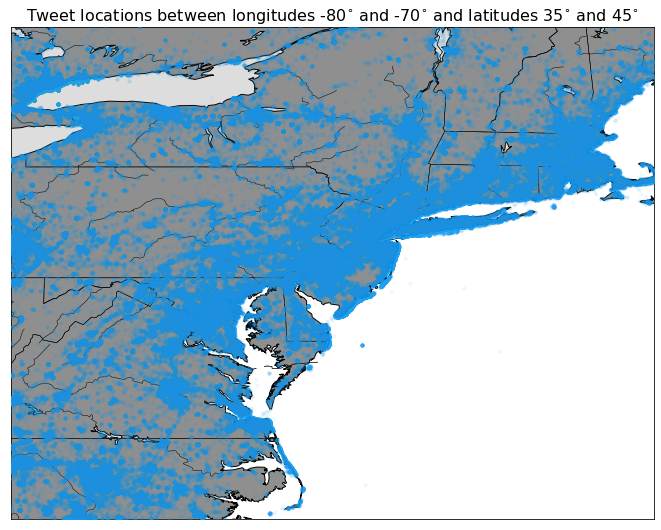

In [8]:
# plot all of the boxes
fig, ax = plt.subplots(figsize=[10, 12])
# sns.scatterplot(x='longitude', y='latitude', data=df, alpha=0.1)
# plt.ylim([35, 45])
# plt.xlim([-80, -70])
m = Basemap(llcrnrlon=-80, llcrnrlat=35, urcrnrlon=-70, urcrnrlat=45,
            resolution='i',projection='cea')
m.drawcoastlines()
m.fillcontinents(color='#606060',lake_color='white', alpha=0.7)
m.drawstates()
m.drawrivers()

# lets filter for the NY tweets only
x, y = m(df1['longitude'].values, df1['latitude'].values)
twitter_blue = (29/255, 161/255, 242/255)
# m.shadedrelief()
m.scatter(x, y, 10, marker='o', color=twitter_blue, zorder=999, alpha=0.05)
plt.title("Tweet locations between longitudes -80$^{\circ}$ and -70$^{\circ}$ and latitudes 35$^{\circ}$ and 45$^{\circ}$", fontsize=16)
ax = plt.gca()
plt.tight_layout()
plt.savefig('map_all.png')
plt.show()

Plot the refined search

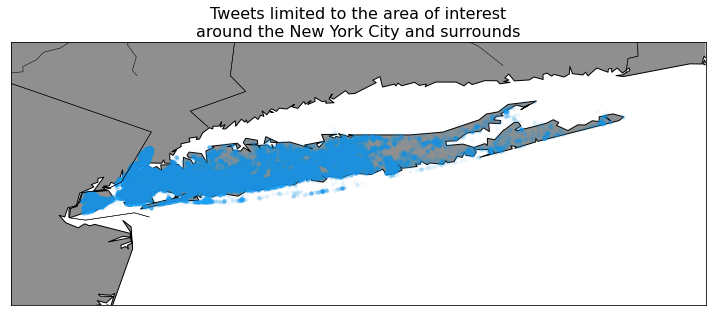

In [9]:
# plot all of the boxes
fig, ax = plt.subplots(figsize=[10, 12])
m = Basemap(llcrnrlon=-74.5, llcrnrlat=40, urcrnrlon=-71.5, urcrnrlat=41.5,
            resolution='i',projection='cea')
m.drawcoastlines()
m.fillcontinents(color='#606060',lake_color='white', alpha=0.7)
m.drawstates(zorder=999)
m.drawrivers()

# lets filter for the NY tweets only
x, y = m(nyc['longitude'].values, nyc['latitude'].values)
twitter_blue = (29/255, 161/255, 242/255)
# m.shadedrelief()
m.scatter(x, y, 10, marker='o', color=twitter_blue, zorder=99, alpha=0.05)
ax = plt.gca()
plt.title("Tweets limited to the area of interest\naround the New York City and surrounds", fontsize=16)
plt.tight_layout()
plt.savefig('local_map.png')
plt.show()

### Plot the data in time
Set the time_stamp as a datetime index

#### Tasks
- adjust for the timezone
- get the weather data and plot this on top of the tweet data

The highest and lowest days are 24-08-14 and 04-12-14


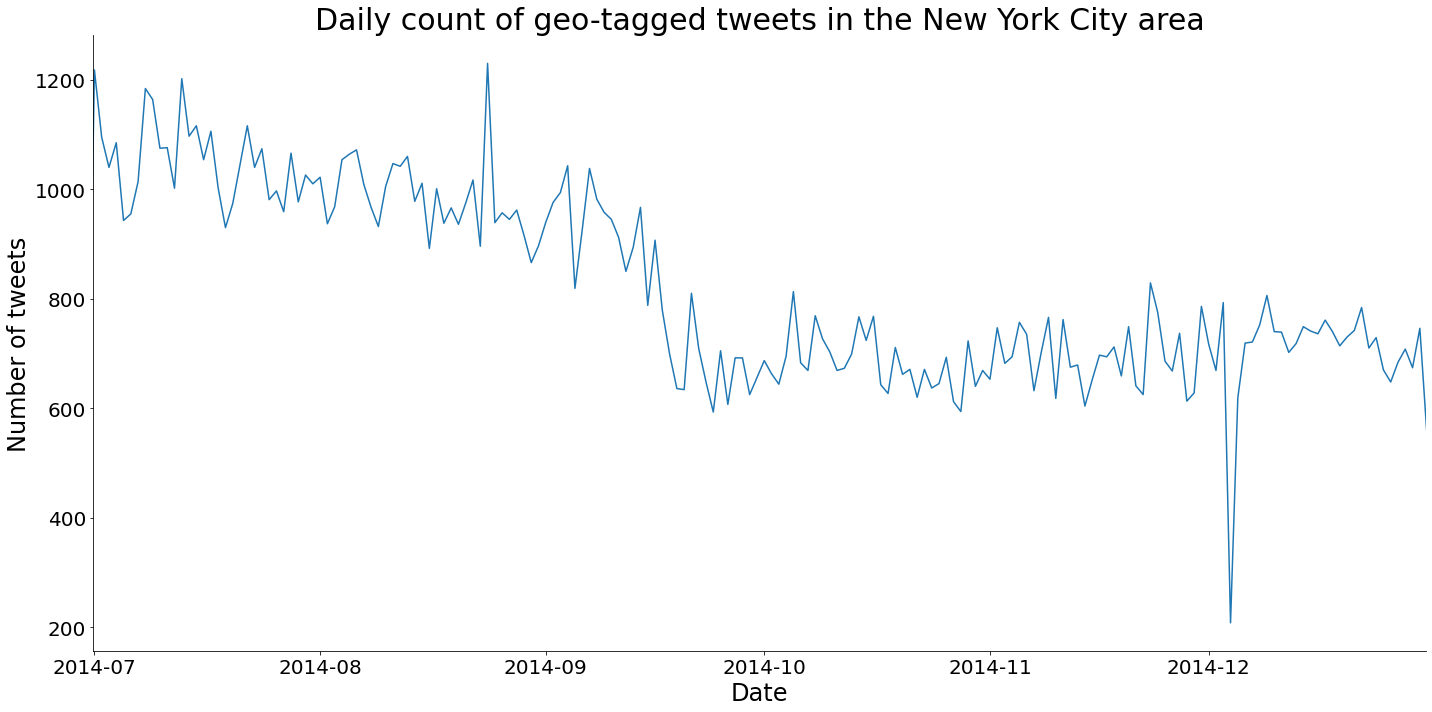

In [10]:
# create date time index and convert to us timezone
time_index = pd.DatetimeIndex(nyc['time_stamp'])
us_index = time_index.tz_convert('US/Eastern')
time_df = nyc.set_index(us_index).sort_index()

# count the number of tweets per day
counts = time_df['id'].resample('1D').count()

# plot the counts over the timeseries
fig, ax = plt.subplots(figsize=[20, 10])
sns.lineplot(counts.index, counts.values)
plt.xlim([pd.to_datetime('2014-07-1'), pd.to_datetime('2014-12-31')])
ax.tick_params(axis='both', which='major', labelsize=16)

# formatting
axis_fs = 24
ax.set_xlabel('Date', fontsize=axis_fs)
ax.set_ylabel('Number of tweets', fontsize=axis_fs)
ax.set_title("Daily count of geo-tagged tweets in the New York City area", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20, reset=False)
sns.despine()
plt.tight_layout()
plt.savefig('daily_counts.png')
print(f"The highest and lowest days are {counts.idxmax().strftime('%d-%m-%y')} and {counts.idxmin().strftime('%d-%m-%y')}")

## Explore the twitter and weather data
- Look at the daily distribution

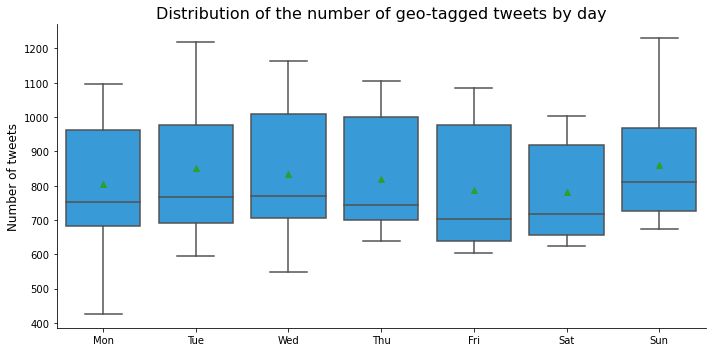

In [11]:
# lets have a look at the days for the week
cdf = counts.reset_index()
# cdf.head() 
cdf['dayofweek'] = cdf['time_stamp'].dt.dayofweek
# cdf.head()

# plot the distribution of tweets over the week
fig, ax = plt.subplots(figsize=[10, 5])
sns.boxplot(x='dayofweek', y='id', data=cdf, color=twitter_blue, showfliers=False, showmeans=True)

# set the xticks to days
xticks = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xlabel(None)
ax.set_ylabel('Number of tweets', fontsize=12)
ax.set_title("Distribution of the number of geo-tagged tweets by day", fontsize=16)
ax.set_xticklabels(xticks)
ax.tick_params(axis='both', which='major', labelsize=10, reset=False)
sns.despine()
plt.tight_layout()
plt.savefig('box_tweets.png')

## Weather data
We have the following fields:
- SNOW: mm or inches of snowfall
- SNWD: mm or inches of snowdepth
- PRCP: mm or inches of rain
- AWND: average daily windspeed ms$^{-1}$ or mph
- TMIN: min temp in f
- TAVG: average temp in f
- TMAX: max temp in f

these are the 89 stations:
['US1NYWC0003' 'US1NJBG0023' 'US1NJES0011' 'USC00280907' 'US1NJES0015'
 'US1NJMD0043' 'US1NJMS0069' 'US1NJPS0005' 'US1NJBG0029' 'US1NJPS0004'
 'US1NJMN0048' 'US1NJMN0006' 'US1NJMD0045' 'US1NJUN0019' 'US1NJUN0018'
 'USW00014732' 'US1NJUN0017' 'US1NJMD0050' 'US1NJUN0016' 'USW00014734'
 'US1NJUN0014' 'US1NYNS0006' 'US1NYNS0007' 'US1NJUN0010' 'US1NYWC0009'
 'US1NJES0020' 'US1NJMD0039' 'US1NJBG0033' 'US1NJES0021' 'US1NJMD0038'
 'US1NJES0024' 'US1NJPS0019' 'US1NJBG0037' 'US1NJHD0002' 'US1NJMS0014'
 'US1NJMS0058' 'US1NJMS0059' 'US1NJPS0015' 'US1NJPS0018' 'US1NJPS0012'
 'US1NYRC0002' 'US1NJMS0011' 'US1NYRC0001' 'US1NJPS0014' 'US1NJMD0033'
 'US1NJMN0032' 'USW00094741' 'US1NJES0018' 'US1NYRL0005' 'US1NJES0019'
 'USW00094745' 'USW00094789' 'USC00289187' 'US1NJBG0030' 'US1NJBG0002'
 'US1NJBG0003' 'US1NJMS0049' 'US1NJBG0006' 'US1NJMS0047' 'US1NJMD0062'
 'US1NJMS0002' 'US1NJPS0022' 'US1NJMD0023' 'US1NJPS0025' 'US1NYKN0025'
 'US1NJMS0040' 'USC00282023' 'USC00301309' 'USC002

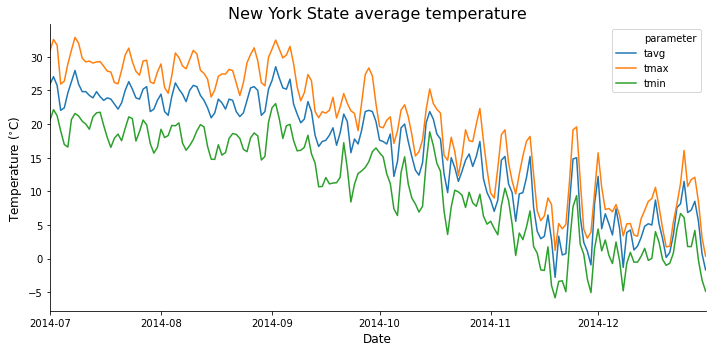

In [12]:
# get the weather data
weather = pd.read_csv(r'datasets\weather.csv', parse_dates=['DATE'], dayfirst=True)
weather.columns = [col.lower() for col in weather.columns]
to_convert = ['tmin', 'tavg', 'tmax']

# print the number of stations
stations = weather['station'].unique()
print(f'these are the {len(stations)} stations:')
print(stations)

# convert temp function
f2c = lambda f: (f-32)*5/9

# melt the temp data for plotting
id_cols = ['station', 'name', 'date']
temps = weather.loc[weather['tmin'].notnull(), id_cols + to_convert]
temps = pd.melt(temps, id_vars=id_cols, value_vars=temps.columns[3:], value_name='value', var_name='parameter')

# group the by parameter and take the average of each parameter
temps['celsius'] = temps['value'].map(f2c)
temps = temps.groupby(['date','parameter'])['celsius'].agg(np.mean).reset_index()
temps = temps[temps['date'] >= pd.to_datetime('2014-7-1')]

# plot the results
fig, ax = plt.subplots(figsize=[10, 5])
sns.lineplot(x='date', y='celsius', hue='parameter', data=temps)
plt.title("New York State average temperature", fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature ($^{\circ}$C)', fontsize=12)
plt.xlim([pd.to_datetime('2014-07-1'), pd.to_datetime('2014-12-31')])
ax.tick_params(axis='both', which='major', labelsize=10, reset=False)
sns.despine()
plt.tight_layout()
plt.savefig('all_temps.png')

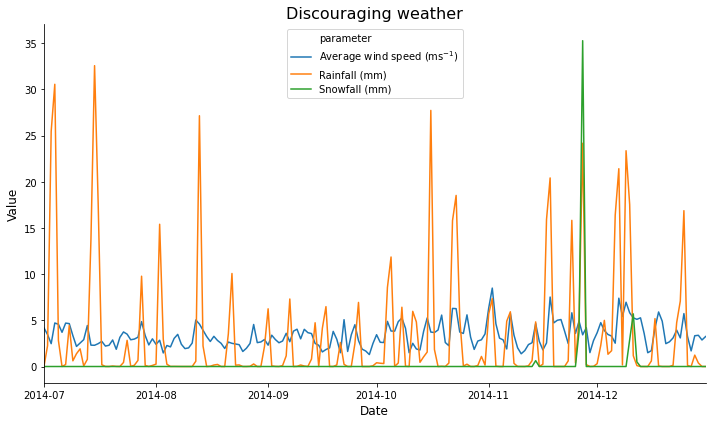

In [13]:
# Let's look at bad stuff that would keep people at home, like:
# - snow, rain and wind
bad_stuff = ['snow', 'prcp', 'awnd']
bsdf = weather.copy()

# conversions
inch2mm = lambda x: 25.4*x
mph2mps = lambda x: 1.6*x/3.6
bsdf['awnd'] = bsdf['awnd'].map(mph2mps)
to_convert = ['snow', 'snwd', 'prcp']
for col in to_convert:
    bsdf[col] = bsdf[col].map(inch2mm)

# melt columns for plotting
id_cols = ['station', 'name', 'date']
bs = bsdf.loc[:, id_cols + bad_stuff]
bs = pd.melt(bs, id_vars=id_cols, value_vars=bs.columns[3:], value_name='value', var_name='parameter').dropna()

# take the average of the values
bs = bs.groupby(['date', 'parameter'])['value'].agg(np.mean).reset_index()

# plot the results
fig, ax = plt.subplots(figsize=[10, 6])

# let's relable for the crowd
to_plot = bs.copy()
relabel = dict(awnd='Average wind speed (ms$^{-1}$)',
               prcp='Rainfall (mm)',
               snow='Snowfall (mm)')
to_plot['parameter'] = to_plot['parameter'].map(relabel)
sns.lineplot(x='date', y='value', hue='parameter', data=to_plot)

# plot formats
plt.title("Discouraging weather", fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
plt.xlim([pd.to_datetime('2014-07-1'), pd.to_datetime('2014-12-31')])
ax.tick_params(axis='both', which='major', labelsize=10, reset=False)
sns.despine()
plt.tight_layout()
plt.savefig('all_bad.png')

### Convert the bad stuff to a categorical for each day
- wind above the 75th percentile is windy
- rain above 5mm is rainy
- snow above 5mm is snowy

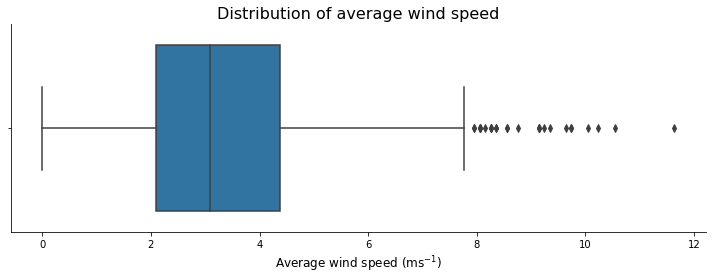

In [14]:
# check windspeed and take the upper percentiles as windy
fig, ax = plt.subplots(figsize=[10, 4])
sns.boxplot(bsdf['awnd'])

# use anything above the 75th percentile as windy
np.percentile(bsdf['awnd'].dropna().values, 75)

# plot formats
plt.title("Distribution of average wind speed", fontsize=16)
ax.set_xlabel('Average wind speed (ms$^{-1}$)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10, reset=False)
sns.despine()
plt.tight_layout()
plt.savefig('wind.png')

### Check for relationships between the data
Use some scatterplots

In [15]:
def show_range(label, index):
    print(f"{label} (n={len(index)}): minimum date {min(counts.index).strftime('%d/%m/%y')}, maximum date {max(counts.index).strftime('%d/%m/%y')}")

In [16]:
counts.head()

time_stamp
2014-06-30 00:00:00-04:00     426
2014-07-01 00:00:00-04:00    1218
2014-07-02 00:00:00-04:00    1095
2014-07-03 00:00:00-04:00    1040
2014-07-04 00:00:00-04:00    1085
Freq: D, Name: id, dtype: int64

In [17]:
# check we have the same index for the weather and count values
show_range('Counts', counts.index)
show_range('Temperature', temps['date'])
show_range('Bad stuff', bs['date'])

Counts (n=185): minimum date 30/06/14, maximum date 31/12/14
Temperature (n=552): minimum date 30/06/14, maximum date 31/12/14
Bad stuff (n=552): minimum date 30/06/14, maximum date 31/12/14


In [18]:
for t in ['tmin', 'tavg', 'tmax']:
    show_range(t, temps[temps['parameter']==t])

for b in ['snow', 'awnd', 'prcp']:
    show_range(b, bs[bs['parameter']==b])

tmin (n=184): minimum date 30/06/14, maximum date 31/12/14
tavg (n=184): minimum date 30/06/14, maximum date 31/12/14
tmax (n=184): minimum date 30/06/14, maximum date 31/12/14
snow (n=184): minimum date 30/06/14, maximum date 31/12/14
awnd (n=184): minimum date 30/06/14, maximum date 31/12/14
prcp (n=184): minimum date 30/06/14, maximum date 31/12/14


Creat a single dataset

In [19]:
def get_variable(df, param, vcol):
    return df[df['parameter']==param].set_index(pd.DatetimeIndex(df[df['parameter']==param]['date'], tz=timezone('US/Eastern')))[vcol].rename(param)

In [21]:
# need to set the timezones
from pytz import timezone
variables = [get_variable(temps, 'tmin', 'celsius'),
             get_variable(temps, 'tavg', 'celsius'),
             get_variable(temps, 'tmax', 'celsius'),
             get_variable(bs, 'snow', 'value'),
             get_variable(bs, 'awnd', 'value'), 
             get_variable(bs, 'prcp', 'value'),
             counts[1:]]
mdf = pd.concat(variables, axis=1).rename(columns=dict(id='num_tweets'))

# include day of the week and temp range, drop the min-max temps and the day of week
mdf['dayofweek'] = mdf.index.dayofweek
mdf['trange'] = mdf['tmax'] - mdf['tmin']
mdf = mdf.drop(['tmax', 'tmin'], axis=1)
mdf.head()

,tavg,snow,awnd,prcp,num_tweets,dayofweek,trange
2014-07-01 00:00:00-04:00,25.925926,0.0,4.187778,0.000000,1218,1,10.341880
2014-07-02 00:00:00-04:00,27.037037,0.0,3.454444,2.256367,1095,2,10.427350
2014-07-03 00:00:00-04:00,25.740741,0.0,2.472778,25.459765,1040,3,10.470085
2014-07-04 00:00:00-04:00,22.037037,0.0,4.710000,30.550338,1085,4,6.965812
2014-07-05 00:00:00-04:00,22.407407,0.0,4.573889,2.819400,943,5,9.401709


c:\users\robmw\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\robmw\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\robmw\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\robmw\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


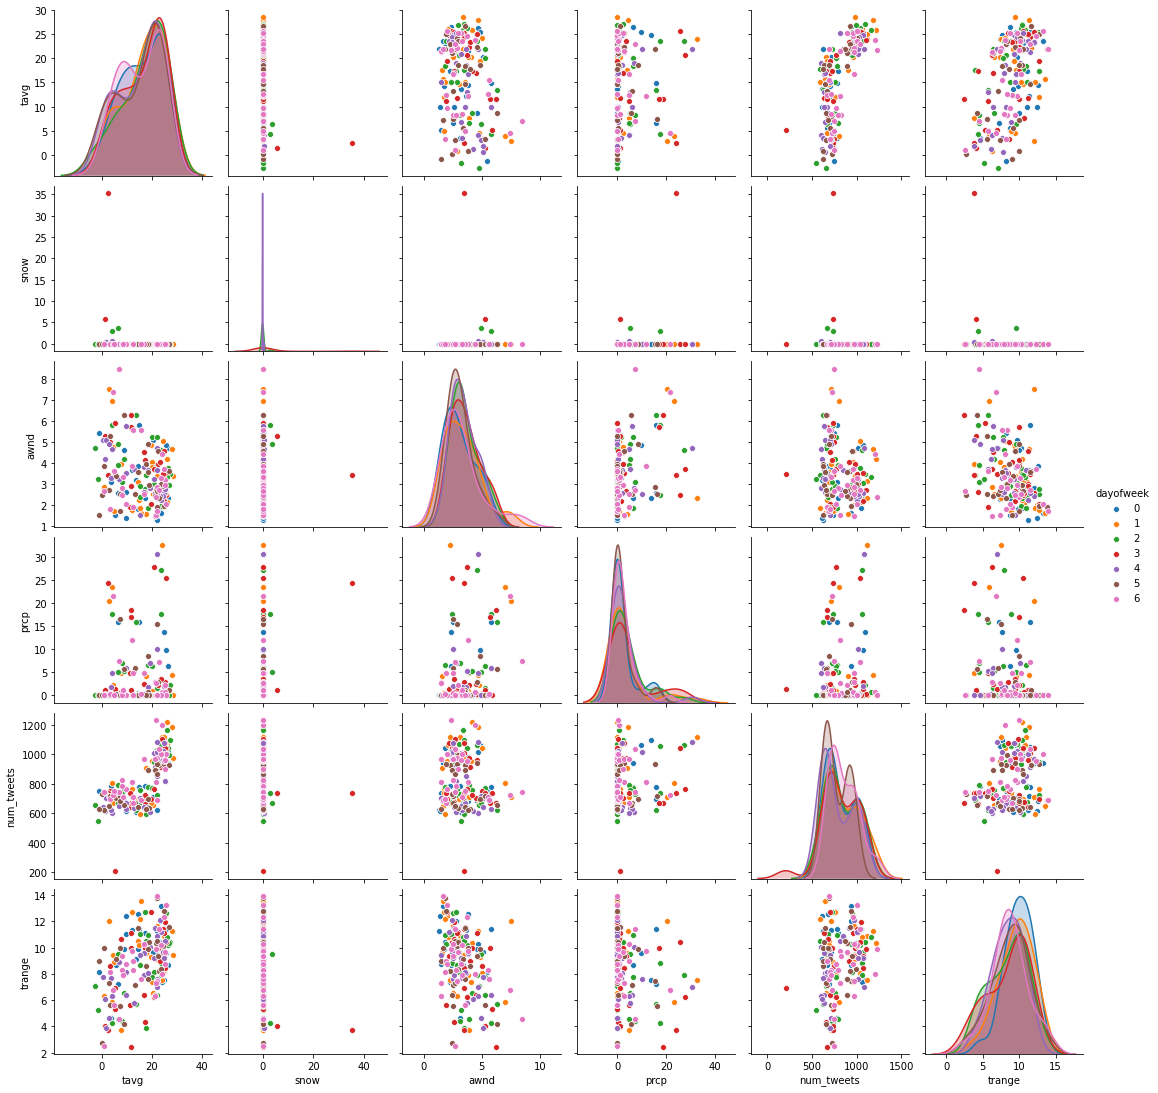

In [22]:
sns.pairplot(mdf, hue='dayofweek')

### Discussion
I can't see any obvious relations with tweet volume other than the temperature and in the line plot there seems to be a shift from the warmer to colder weather

## Model the response
Try predicting the response with a bunch of models

#### tasks:
- scale the data
- use regularisation
- turn rain and snow into cats

In [23]:
# get the some modelling tools
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn import preprocessing

# lets use our work from Assingment 3 to see if any models can predict tweet volume from the data given to us?
def validate(X, y, model, verbose=False):
    """
    Calculate the ten-folder cross-validation loss    
    """
    # instantiate kfold
    kf = KFold(n_splits=10)
        
    # split the data
    kf.get_n_splits(X)
    
    # loop through and calculate the loss
    losses = list()
    for train_index, test_index, in kf.split(X):
        # index the training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # train a linear model on the test set
        model.fit(X_train, y_train)
        
        # make a prediction
        y_predict = model.predict(X_test)
        
        # score the loss
        loss = metrics.mean_squared_error(y_test, y_predict)
        losses.append(loss)
        
    # take the average of the losses
    mse = np.mean(losses)
    if verbose:
        print(f"Cross-validation error: {mse:0.0f}")
    return mse

def process_data(df, to_cat, response):
    '''
    categorise and scale the data
    return two arrays in a tuple (X, y)
    '''
    # get the predictors
    pred = df.copy().drop([response], axis=1)
    
    # categories to ones and zeros using a threshold
    for cat in to_cat:
        pred[cat[0]] = pred[cat[0]].map(lambda x: 0 if x < cat[1] else 1)
        
    # scale the rest
    return preprocessing.scale(pred.values), df[response].values
    
def lasso(X, y, lambda_lims, max_iter, verbose=False):
    """
    Find the best lambda for Lasso regularization
    """
    # get a range of lambdas
    lambdas = np.linspace(lambda_lims[0], lambda_lims[1], endpoint=True)
    
    # loop through the lambdas and validate each
    losses = list()
    for l in lambdas:
        # print the lambda
        if verbose:
            print(l)
        
        # instantiate a model
        model = Lasso(alpha=l, max_iter=max_iter)
        
        # validate the model
        loss = validate(X, y, model)
        losses.append(loss)
        
    # plot the result
    fig, ax = plt.subplots()
    plt.plot(lambdas, losses)
    plt.title("Figure 3: Mean-squared-error with Lasso regularization")
    plt.xlabel("lambda")
    plt.ylabel("Cross-validation loss")
    
    # print the best lambda
    best_lambda = lambdas[np.argmin(losses)]
    print(f"Applying Lasso regression with lambda of {best_lambda:0.1f} minimises the loss to {min(losses):0.0f}")

Applying Lasso regression with lambda of 5.7 minimises the loss to 18019


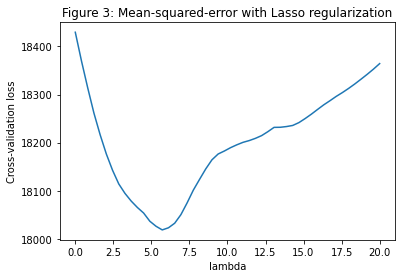

In [24]:
# preprocess the data
X, y = process_data(mdf, [('snow', 5), ('prcp', 10), ('awnd', 4.5)], 'num_tweets')

# have a go at Lasso regression
lasso(X, y, lambda_lims=[0.001, 20], max_iter=100000)

Lasso regression with a lambda of 5.7 works best, how does in perform?

The the highest and lowest predicted dates were 02-09-14 and 19-11-14


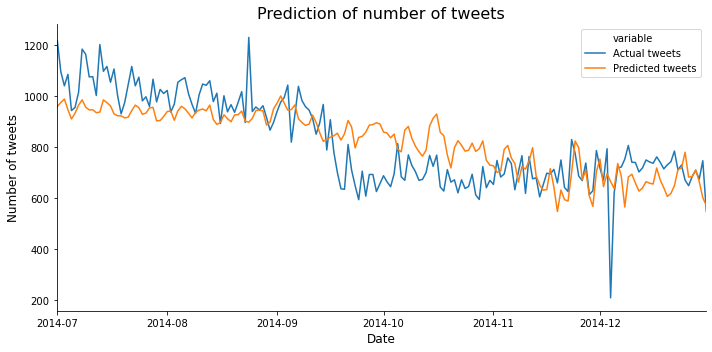

In [25]:
model = Lasso(alpha=5.7, max_iter=1000)
model.fit(X, y)
prediction = model.predict(X)

# lets have a look at how the prediction tracks with the actual values
mdf['predict'] = prediction
to_plot = pd.melt(mdf.loc[:, ['num_tweets', 'predict']].reset_index(), id_vars=['index'], value_vars=['num_tweets', 'predict'], value_name='count')

# plot the result
relabel = dict(num_tweets='Actual tweets',
               predict='Predicted tweets')
#                snow='Snowfall (mm)')
to_plot['variable'] = to_plot['variable'].map(relabel)
fig, ax = plt.subplots(figsize=[10, 5])
sns.lineplot(x='index', y='count', hue='variable', data=to_plot)
to_plot.head()

# plot formats
plt.title("Prediction of number of tweets", fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of tweets', fontsize=12)
plt.xlim([pd.to_datetime('2014-07-1'), pd.to_datetime('2014-12-31')])
ax.tick_params(axis='both', which='major', labelsize=10, reset=False)
sns.despine()
plt.tight_layout()
plt.savefig('prediction.png')
print(f"The the highest and lowest predicted dates were {mdf['predict'].idxmax().strftime('%d-%m-%y')} and {mdf['predict'].idxmin().strftime('%d-%m-%y')}")

In [26]:
print(model.intercept_)
print(model.coef_)
print(model.score(X, y))

822.2391304347826
[123.67284702   4.24455132   0.          10.41053676   0.
  -8.92394831]
0.5325145141208144


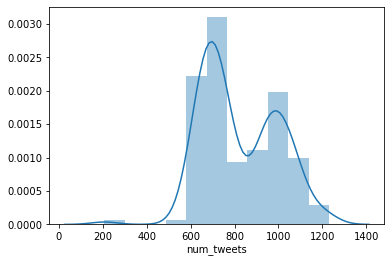

In [27]:
residuals = mdf['predict'] = mdf['num_tweets']
sns.distplot(residuals)

## Modelling
But we haven't tested it on new data - this could be a next step

## What's going on on the outlier days?
Get the hashtags from our region of interest on the highest and lowest days to see what people are talking about

In [28]:
# get the hash tag data
all_data = []
for file in os.listdir('hash_tags'):
    temp = pd.read_csv(os.path.join('hash_tags', file))
    all_data.append(temp)
tags_raw = pd.concat(all_data).reset_index(drop=True)
print(len(tags_raw))
print(tags_raw.head())

# set the timezone and the locations and then filter like with the above datasets
tags_raw = tags_raw.set_index(pd.DatetimeIndex(tags_raw['time_stamp']).tz_convert('US/Eastern'), drop=True)
tags_raw['date'] = tags_raw.index.date
# tags_raw.head()

# filter for the locations
with_locs = get_locations(tags_raw.reset_index(drop=True))
filtered = with_locs[with_locs['county'].isin(ny_counties)]
filtered.head()

51793
                   id                time_stamp  \
0  483746608329146368  2014-06-30T22:59:13.000Z   
1  483750991372623874  2014-06-30T23:16:38.000Z   
2  483757844882530304  2014-06-30T23:43:52.000Z   
3  483760449532338176  2014-06-30T23:54:13.000Z   
4  483761519097032705  2014-06-30T23:58:28.000Z   

                                   hashtags  longitude   latitude      type  
0             ({(maverickradio),(hotmess)}) -73.873522  40.728526  centroid  
1                          ({(HobbyLobby)}) -73.977142  40.780881  centroid  
2                  ({(european),(antibes)}) -73.873522  40.728526  centroid  
3                    ({(Pride),(NYCPride)}) -73.977142  40.780881  centroid  
4  ({(CT),(FamousPizza),(SoNo),(Hometown)}) -73.199119  41.185674  centroid  


,id,time_stamp,hashtags,longitude,latitude,type,date,city_lat,city_lon,city,state,county,cc
0,483746608329146368,2014-06-30T22:59:13.000Z,"({(maverickradio),(hotmess)})",-73.873522,40.728526,centroid,2014-06-30,40.68149,-73.83652,Borough of Queens,New York,Queens County,US
1,483750991372623874,2014-06-30T23:16:38.000Z,({(HobbyLobby)}),-73.977142,40.780881,centroid,2014-06-30,40.78343,-73.96625,Manhattan,New York,New York County,US
2,483757844882530304,2014-06-30T23:43:52.000Z,"({(european),(antibes)})",-73.873522,40.728526,centroid,2014-06-30,40.68149,-73.83652,Borough of Queens,New York,Queens County,US
3,483760449532338176,2014-06-30T23:54:13.000Z,"({(Pride),(NYCPride)})",-73.977142,40.780881,centroid,2014-06-30,40.78343,-73.96625,Manhattan,New York,New York County,US
5,483771073725739008,2014-07-01T00:36:26.000Z,({(YorkRevs)}),-73.873522,40.728526,centroid,2014-06-30,40.68149,-73.83652,Borough of Queens,New York,Queens County,US


In [29]:
def get_datewords(date, date_col, word_col, df):
    '''
    extract the outlier words from the data
    '''
    
    # filter by date
    by_date = df[df[date_col]==date]
    
    # remove the parenthesis from the words
    words = by_date[word_col].str.replace(r"[({})\s]", "").str.lower().str.split(",")
    
    all_words = list()
    for tags in words:
        all_words += [t.strip() for t in tags]
    return all_words

In [30]:
from wordcloud import WordCloud

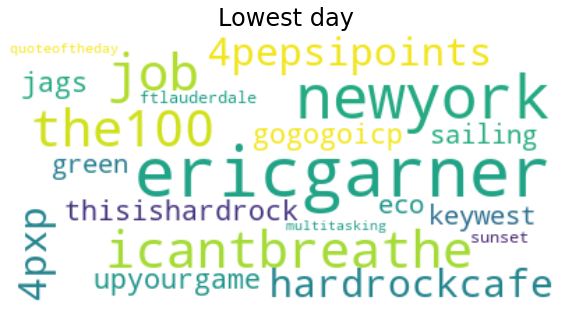

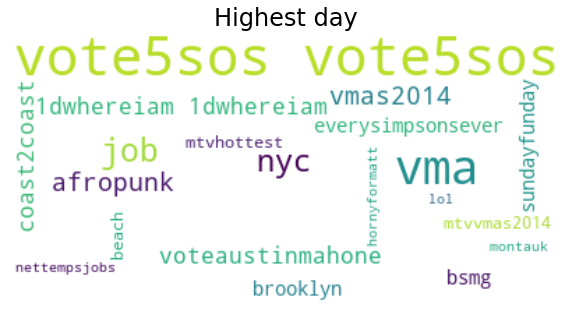

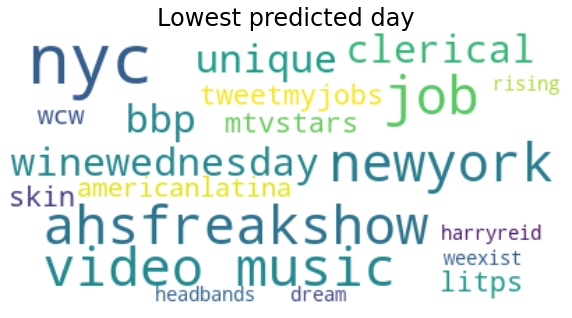

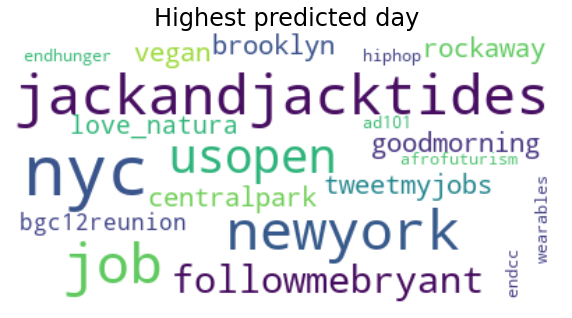

In [31]:
# filter for the outlier dates
low_date = pd.to_datetime('2014-12-04')
high_date = pd.to_datetime('2014-08-24')
pred_low = pd.to_datetime('2014-11-19')
pred_high = pd.to_datetime('2014-09-02')
outliers = [low_date, high_date, pred_low, pred_high]
labels = ['Lowest day', 'Highest day', 'Lowest predicted day', 'Highest predicted day']
words = list()
for label, date in zip(labels, outliers):
    words = get_datewords(date, 'date', 'hashtags', filtered)    
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(" ".join(words))
    plt.figure(figsize=[10, 6])
    plt.title(label, fontsize=24)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(f"{label}.png")
    plt.show()